In [1]:
import torch
import math
import numpy as np
import xalglib
import matplotlib.pyplot as plt

from sklearn.datasets import load_breast_cancer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import log_loss

from time import clock_gettime, CLOCK_MONOTONIC
from CubicEquationSolver import solve as solve_cubic

# Problem

## sklearn: LogisticRegression

In [2]:
X, y = load_breast_cancer(True)
X = (X - X.mean(axis=0)) / X.std(axis=0) + np.random.randn(*X.shape)
X = np.concatenate((X, np.ones((X.shape[0], 1))), axis=1)

In [3]:
log_reg = LogisticRegression(penalty='none', fit_intercept=False, solver='newton-cg', tol=1e-7)
log_reg.fit(X, y)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=False,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='none',
                   random_state=None, solver='newton-cg', tol=1e-07, verbose=0,
                   warm_start=False)

In [4]:
x_opt = log_reg.coef_[0]

In [5]:
x_opt

array([-0.47491485, -0.67589047, -0.42380624, -0.42162855, -0.46431844,
       -0.44689983, -0.44442   , -0.44512456, -0.0872136 ,  0.48511295,
       -0.48194139,  0.09711006, -0.09881679, -0.02742667, -0.14806337,
        0.08949782,  0.20093349, -0.01777249,  0.3476606 ,  0.05614124,
       -0.18288483, -0.63597032, -0.7093087 , -0.11174879,  0.0624489 ,
       -0.05757022, -0.73590512, -0.88896192, -0.62490268,  0.10882618,
        1.30695373])

In [6]:
log_reg.score(X, y)

0.9349736379613357

In [7]:
log_loss(y, log_reg.predict_proba(X))

0.14533202420062924

## PyTorch: optimization problem

In [8]:
X = torch.tensor(X, dtype=torch.float32)
y = torch.tensor(y, dtype=torch.float32)

x_opt = torch.tensor(x_opt, dtype=torch.float32)
N = x_opt.shape[0]

x_0 = torch.randn(N)

In [9]:
def f(x):
    return torch.nn.functional.binary_cross_entropy_with_logits(X @ x, y)

In [10]:
f(x_opt).item()

0.1453319787979126

In [11]:
f(x_0).item()

3.333508014678955

In [12]:
def check_optimality(f, x, step=1e-4, eps=1e-7):
    n = x.shape[0]
    fx = f(x)
    for i in range(n):
        for s in [-1, 1]:
            y = x.clone()
            y[i] += s * step
            fy = f(y)
            if fy < fx - eps:
                return False
    return True

In [13]:
check_optimality(f, x_0)

False

In [14]:
check_optimality(f, x_opt)

True

# Helper functions

In [15]:
def d_p(x, p):
    return 1 / p * torch.norm(x)**p


def gradient(f, x, create_graph=False, retain_graph=None):
    return torch.autograd.grad(
        outputs=[f],
        inputs=[x],
        create_graph=create_graph, 
        retain_graph=retain_graph)[0]


def hessian(f, x, create_graph=False):
    n = x.shape[0]
    h = torch.empty(n, n)
    g = gradient(f, x, True)
    for i in range(n):
        h[i] = gradient(g[i], x, create_graph, True)
    return h


def D3(f, x, create_graph=False):
    n = x.shape[0]
    d3 = torch.empty(n, n, n)
    g = gradient(f, x, True)
    for i in range(n):
        d3[i] = hessian(g[i], x, create_graph)
    return d3


def hessian_vector_product(f, x, v, retain_graph=False):
    grad_f = gradient(f, x, True)
    return gradient(grad_f @ v, x, retain_graph=retain_graph)

In [16]:
def test():
    x = torch.tensor([1.5, 2.5], requires_grad=True)
    e = torch.tensor([1., 1.])
    f = x.pow(2).prod()
    print('F =', f, '\n')

    g = gradient(f, x, retain_graph=True)
    print('g =', g, '\n')

    h = hessian(f, x)
    print('h =', h, '\n')

    he = hessian_vector_product(f, x, e, retain_graph=True)
    print('h @ e =', he, '\n')
    
    d3 = D3(f, x)
    print('d3 =', d3, '\n')

test()

F = tensor(14.0625, grad_fn=<ProdBackward0>) 

g = tensor([18.7500, 11.2500]) 

h = tensor([[12.5000, 15.0000],
        [15.0000,  4.5000]]) 

h @ e = tensor([27.5000, 19.5000]) 

d3 = tensor([[[ 2.8610e-06,  1.0000e+01],
         [ 1.0000e+01,  6.0000e+00]],

        [[ 1.0000e+01,  6.0000e+00],
         [ 6.0000e+00, -1.4305e-06]]]) 



# Auxilary problem

In [17]:
def auxilary_problem_objective(h, A, c, gamma):
    value = .5 * A @ h @ h + c @ h + gamma * torch.norm(h)**4 / 4
    return value

## Original problem

In [18]:
def solve_auxilary_problem_autograd_vanilla_gd(A, c, gamma, h_0, learning_rate=0.001, n_iter=1000):
    h = h_0.clone().detach().requires_grad_()
    for i in range(n_iter):
        value = auxilary_problem_objective(h, A, c, gamma)
        grad = gradient(value, h)
        with torch.no_grad():
            h -= learning_rate * grad
    return h


def solve_auxilary_problem_analytic_vanilla_gd(A, c, gamma, h_0, learning_rate=0.001, n_iter=1000):
    h = h_0.clone().detach().requires_grad_()
    for i in range(n_iter): 
        grad = A @ h + c + gamma * torch.norm(h)**2 * h
        with torch.no_grad():
            h -= learning_rate * grad
    return h


def solve_auxilary_problem_analytic_gd_grad_norm(A, c, gamma, h_0, learning_rate=0.001, min_grad_norm=1e-3):
    h = h_0.clone().detach().requires_grad_()
    while True:
        grad = A @ h + c + gamma * torch.norm(h)**2 * h
        grad_norm = torch.norm(grad)
        if grad_norm < min_grad_norm:
            break
        with torch.no_grad():
            h -= learning_rate * grad
    return h


def solve_auxilary_problem_exact_gd_np(A, c, gamma, h_0, min_step_size=1e-5):
    h = h_0.clone().detach().requires_grad_()
    
    def opt_learning_rate():
        gh = g @ h
        hh = h_norm ** 2
        gg = g_norm ** 2
        a3 =      gamma * gg**2
        a2 = -3 * gamma * gg * gh
        a1 =  gamma * hh * gg + 2 * gamma * gh**2 + A @ g @ g
        a0 = -gamma * hh * gh - Ah @ g - c @ g
        root = [r.real for r in np.roots([a3, a2, a1, a0]) if r.imag == 0][0]
        return root
    
    while True:
        h_norm = torch.norm(h)
        Ah = A @ h
        g = Ah + c + gamma * h_norm**2 * h
        g_norm = torch.norm(g)
        learning_rate = opt_learning_rate()
        if g_norm * learning_rate < min_step_size:
            break
        with torch.no_grad():
            h -= learning_rate * g
    return h


def solve_auxilary_problem_exact_gd(A, c, gamma, h_0, min_step_size=1e-5):
    h = h_0.clone().detach().requires_grad_()
    
    def opt_learning_rate():
        gh = g @ h
        gg = g_norm ** 2
        gamma_gg = gamma * gg
        gamma_hh = gamma * hh
        a3 =      gamma_gg * gg
        a2 = -3 * gamma_gg * gh
        a1 =  gamma_hh * gg + 2 * gamma * gh**2 + A @ g @ g
        a0 = -gamma_hh * gh - Ah @ g - c @ g
        root = [r.real for r in solve_cubic(a3.item(), a2.item(), a1.item(), a0.item()) if r.imag == 0][0]
        return root
    
    while True:
        h_norm = torch.norm(h)
        Ah = A @ h
        hh = h_norm ** 2
        g = Ah + c + gamma * hh * h
        g_norm = torch.norm(g)
        learning_rate = opt_learning_rate()
        if g_norm * learning_rate < min_step_size:
            break
        with torch.no_grad():
            h -= learning_rate * g
    return h


def solve_auxilary_problem_exact_newton(A, c, gamma, h_0, eps=1e-7):
    h = h_0.clone().detach().requires_grad_()
    
    def opt_learning_rate():
        sh = s @ h
        ss = s_norm ** 2
        gamma_ss = gamma * ss
        gamma_hh = gamma * hh
        a3 =      gamma_ss * ss
        a2 = -3 * gamma_ss * sh
        a1 =  gamma_hh * ss + 2 * gamma * sh**2 + A @ s @ s
        a0 = -gamma_hh * sh - Ah @ s - c @ s
        root = [r.real for r in solve_cubic(a3.item(), a2.item(), a1.item(), a0.item()) if r.imag == 0][0]
        return root
    
    def outer(a, b):
        return torch.unsqueeze(a, 1) @ torch.unsqueeze(b, 0)
    
    I = torch.eye(len(c))
    while True:
        h_norm = torch.norm(h)
        Ah = A @ h
        hh = h_norm ** 2
        g = Ah + c + gamma * hh * h
        H = A + gamma * (2 * outer(h, h) + hh**2 * I)
        s = torch.inverse(H) @ g
        lmb_square = s @ g
        s_norm = torch.norm(s)
        learning_rate = opt_learning_rate()
        if lmb_square < eps:
            break
        with torch.no_grad():
            h -= learning_rate * s
    return h

In [19]:
def test(solve, N):
    times = []
    for _ in range(N):
        A = torch.diag(torch.abs(torch.randn(4)))
        k = 1
        e_k = torch.zeros(4)
        e_k[k] = 1
        c = (10 + 10 * torch.abs(torch.randn(1))) * e_k
        gamma = 100 * torch.abs(torch.randn(1))
        h_0 = torch.ones_like(c)
        
        start = clock_gettime(CLOCK_MONOTONIC)
        h = solve(A, c, gamma, h_0)
        end = clock_gettime(CLOCK_MONOTONIC)
        times.append(end - start)
    
    print('A =', A, '\n')
    print('c =', c, '\n')
    print('gamma =', gamma, '\n')
    
    print('Time:', np.mean(times), '\n')
    print('h =', h)

    def f(h):
        return c @ h + .5 * h.T @ A @ h + gamma * torch.norm(h)**4 / 4

    xx = np.linspace(-2, 2, 1000)
    yy = [f(x * e_k) for x in xx]
    plt.plot(xx, yy)
    y1, y2 = min(yy) - 10, min(yy) + 100
    plt.ylim(y1, y2)
    plt.plot([h[k], h[k]], [y1, y2])

A = tensor([[0.5504, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.8717, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.6552, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.2944]]) 

c = tensor([ 0.0000, 10.0088,  0.0000,  0.0000]) 

gamma = tensor([21.1941]) 

Time: 0.26460410799772943 

h = tensor([ 2.6391e-06, -7.6113e-01,  2.3734e-06,  3.4203e-06],
       requires_grad=True)


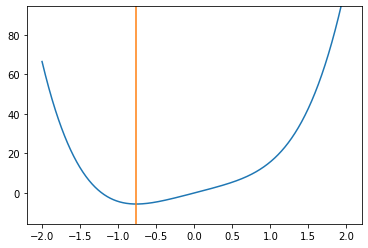

In [20]:
test(lambda A, c, gamma, h_0: solve_auxilary_problem_autograd_vanilla_gd(A, c, gamma, h_0), 10)

A = tensor([[0.6735, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.3831, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.5598, 0.0000],
        [0.0000, 0.0000, 0.0000, 1.2064]]) 

c = tensor([ 0.0000, 13.6874,  0.0000,  0.0000]) 

gamma = tensor([105.0011]) 

Time: 0.052879347360576506 

h = tensor([ 6.2351e-13, -5.0464e-01,  7.0091e-13,  3.6034e-13],
       requires_grad=True)


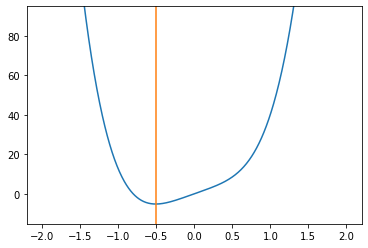

In [21]:
test(lambda A, c, gamma, h_0: solve_auxilary_problem_analytic_vanilla_gd(A, c, gamma, h_0), 100)

A = tensor([[0.2543, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.1371, 0.0000, 0.0000],
        [0.0000, 0.0000, 2.3172, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.8595]]) 

c = tensor([ 0.0000, 18.4397,  0.0000,  0.0000]) 

gamma = tensor([81.0532]) 

Time: 0.044789253898488826 

h = tensor([ 2.3560e-05, -6.0954e-01,  1.1367e-05,  1.9028e-05],
       requires_grad=True)


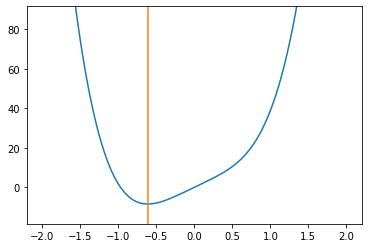

In [22]:
test(lambda A, c, gamma, h_0: solve_auxilary_problem_analytic_gd_grad_norm(A, c, gamma, h_0), 10)

A = tensor([[0.6099, 0.0000, 0.0000, 0.0000],
        [0.0000, 1.0547, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.3447, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.4057]]) 

c = tensor([ 0.0000, 14.7075,  0.0000,  0.0000]) 

gamma = tensor([58.3372]) 

Time: 0.005482825413942919 

h = tensor([-3.4549e-06, -6.2219e-01, -4.2231e-06, -4.0339e-06],
       requires_grad=True)


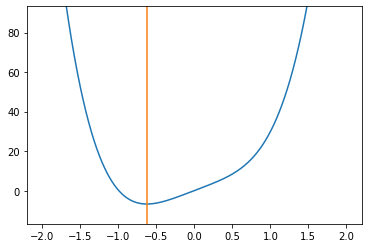

In [23]:
test(lambda A, c, gamma, h_0: solve_auxilary_problem_exact_gd_np(A, c, gamma, h_0), 1000)

A = tensor([[2.0363, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.4640, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.1786, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.1718]]) 

c = tensor([ 0.0000, 25.2483,  0.0000,  0.0000]) 

gamma = tensor([50.2921]) 

Time: 0.003501675920051639 

h = tensor([-2.4247e-06, -7.9090e-01, -6.5542e-06, -6.5773e-06],
       requires_grad=True)


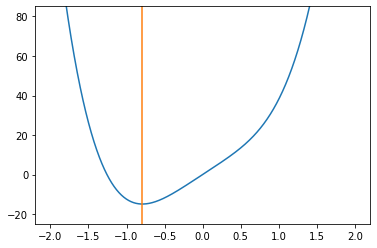

In [24]:
test(lambda A, c, gamma, h_0: solve_auxilary_problem_exact_gd(A, c, gamma, h_0), 1000)

A = tensor([[0.5362, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.3358, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.3272, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.5745]]) 

c = tensor([ 0.0000, 11.6401,  0.0000,  0.0000]) 

gamma = tensor([196.9587]) 

Time: 0.0023529011090286074 

h = tensor([ 1.2962e-06, -3.8806e-01,  1.6218e-05,  6.0991e-07],
       requires_grad=True)


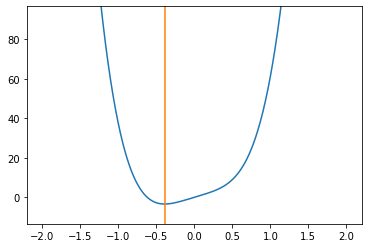

In [25]:
test(lambda A, c, gamma, h_0: solve_auxilary_problem_exact_newton(A, c, gamma, h_0), 1000)

## One dimensional equivalent problem

In [26]:
def auxilary_subproblem_objective(tau, T, c_tilda, gamma):
    I = torch.eye(len(c_tilda))
    value = tau**2 + .5 * c_tilda.T @ torch.inverse(2 * math.sqrt(gamma) * tau * I + T) @ c_tilda
    return value

In [27]:
def tridiag(d, e):
    return torch.diag(d) + torch.diag(e, -1) + torch.diag(e, 1)


def utu_decomposition(A):  # TODO
    a = A.tolist()
    N = len(a)
    a, tau, d, e = xalglib.smatrixtd(a, N, True)
    u = xalglib.smatrixtdunpackq(a, N, True, tau)
    U = torch.tensor(u)
    T = tridiag(torch.tensor(d), torch.tensor(e))
    return T, U


def solve_auxilary_subproblem_autograd_vanilla_gd(T, c_tilda, gamma, tau_0, learning_rate=0.1, n_iter=100):
    tau = tau_0.clone().detach().requires_grad_()
    for i in range(n_iter):
        value = auxilary_subproblem_objective(tau, T, c_tilda, gamma)
        g = gradient(value, tau)
        with torch.no_grad():
            tau -= learning_rate * g
    return tau


def solve_auxilary_subproblem_analytic_vanilla_gd(T, c_tilda, gamma, tau_0, learning_rate=0.1, n_iter=100):
    tau = tau_0.clone().detach().requires_grad_()
    I = torch.eye(len(c_tilda))
    for i in range(n_iter):
        B = torch.inverse(2 * math.sqrt(gamma) * tau * I + T)
        g = 2 * tau - math.sqrt(gamma) * B @ B @ c_tilda @ c_tilda
        with torch.no_grad():
            tau -= learning_rate * g
    return tau


def solve_auxilary_subproblem_analytic_gd_grad_norm(T, c_tilda, gamma, tau_0, learning_rate=0.1, min_grad_norm=1e-3):
    tau = tau_0.clone().detach().requires_grad_()
    I = torch.eye(len(c_tilda))
    while True:
        B = torch.inverse(2 * math.sqrt(gamma) * tau * I + T)
        g = 2 * tau - math.sqrt(gamma) * B @ B @ c_tilda @ c_tilda
        g_norm = torch.norm(g)
        if g_norm < min_grad_norm:
            break
        with torch.no_grad():
            tau -= learning_rate * g
    return tau


def solve_auxilary_subproblem_newton(T, c_tilda, gamma, tau_0, eps=1e-7):
    tau = tau_0.clone().detach().requires_grad_()
    I = torch.eye(len(c_tilda))
    while True:
        B = torch.inverse(2 * math.sqrt(gamma) * tau * I + T)
        B2 = B @ B
        B3 = B2 @ B
        g = 2 * tau - math.sqrt(gamma) * B2 @ c_tilda @ c_tilda
        H = 2 + 4 * gamma * B3 @ c_tilda @ c_tilda
        s = g / H
        lmb_square = s * g
        if lmb_square < eps:
            break
        with torch.no_grad():
            tau -= s
    return tau


def solve_auxilary_problem_utu(A, c, gamma, solve_auxilary_subproblem, state=None):
    if state is None:
        T, U = utu_decomposition(A)
        tau_0 = torch.tensor(1, dtype=torch.float32, requires_grad=True)
    else:
        T, U, tau_0 = state
    c_tilda = U.T @ c
    
    tau = solve_auxilary_subproblem(T, c_tilda, gamma, tau_0)
    assert tau > 0
    I = torch.eye(len(c_tilda))
    h = -U @ torch.inverse(2 * math.sqrt(gamma) * tau * I + T) @ c_tilda
    
    state = T, U, tau
    
    return h, state

In [28]:
def test():
    A = torch.tensor([
        [-1, -2, 1, 2],
        [-2, 3, 0, -2],
        [1, 0, 2, 1],
        [2, -2, 1, 4]
    ], dtype=torch.float32)
    c = torch.ones(4)
    gamma = 1

    T, U = utu_decomposition(A)
    print('A =', A, '\n')
    print('T =', T, '\n')
    print('U =', U, '\n')
    print('U @ T @ U.T =', U @ T @ U.T, '\n')

test()

A = tensor([[-1., -2.,  1.,  2.],
        [-2.,  3.,  0., -2.],
        [ 1.,  0.,  2.,  1.],
        [ 2., -2.,  1.,  4.]]) 

T = tensor([[ 1.9867,  0.9067,  0.0000,  0.0000],
        [ 0.9067, -1.3200, -1.6667,  0.0000],
        [ 0.0000, -1.6667,  3.3333, -3.0000],
        [ 0.0000,  0.0000, -3.0000,  4.0000]]) 

U = tensor([[ 0.1333, -0.7333, -0.6667,  0.0000],
        [-0.3333, -0.6667,  0.6667,  0.0000],
        [-0.9333,  0.1333, -0.3333,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  1.0000]]) 

U @ T @ U.T = tensor([[-1.0000e+00, -2.0000e+00,  1.0000e+00,  2.0000e+00],
        [-2.0000e+00,  3.0000e+00,  8.1956e-08, -2.0000e+00],
        [ 1.0000e+00,  0.0000e+00,  2.0000e+00,  1.0000e+00],
        [ 2.0000e+00, -2.0000e+00,  1.0000e+00,  4.0000e+00]]) 



In [29]:
def test(solve, N):
    A = torch.diag(torch.abs(torch.randn(4)))
    k = 1
    e_k = torch.zeros(4)
    e_k[k] = 1
    c = (10 + 10 * torch.abs(torch.randn(1))) * e_k
    gamma = 100 * torch.abs(torch.randn(1))
    
    T, U = utu_decomposition(A)
    tau_0 = torch.tensor(1, dtype=torch.float32, requires_grad=True)
    
    state = T, U, tau_0
    
    times = []
    for i in range(N):
        start = clock_gettime(CLOCK_MONOTONIC)
        h, _ = solve(A, c, gamma, state)
        end = clock_gettime(CLOCK_MONOTONIC)
        times.append(end - start)
    
    print('A =', A, '\n')
    print('c =', c, '\n')
    print('gamma =', gamma, '\n')
    
    print('Time:', np.mean(times), '\n')
    print('h =', h)

    def f(h):
        return c @ h + .5 * h.T @ A @ h + gamma * torch.norm(h)**4 / 4

    xx = np.linspace(-2, 2, 1000)
    yy = [f(x * e_k) for x in xx]
    plt.plot(xx, yy)
    y1, y2 = min(yy) - 10, min(yy) + 100
    plt.ylim(y1, y2)
    plt.plot([h[k], h[k]], [y1, y2])

A = tensor([[2.3938, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.1161, 0.0000, 0.0000],
        [0.0000, 0.0000, 1.0347, 0.0000],
        [0.0000, 0.0000, 0.0000, 1.3629]]) 

c = tensor([ 0.0000, 21.5628,  0.0000,  0.0000]) 

gamma = tensor([25.1548]) 

Time: 0.26668743769987485 

h = tensor([ 0.0000, -0.9490,  0.0000,  0.0000], grad_fn=<MvBackward>)


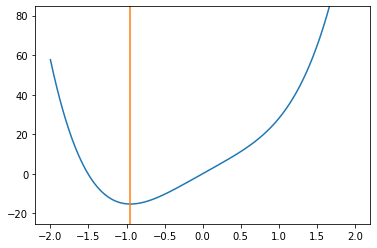

In [30]:
test(lambda A, c, gamma, state: 
     solve_auxilary_problem_utu(A, c, gamma, 
                                lambda T, c_tilda, gamma, tau_0: solve_auxilary_subproblem_autograd_vanilla_gd(T, c_tilda, gamma, tau_0, learning_rate=0.001, n_iter=1000), 
                                state), 
    10)

A = tensor([[0.4537, 0.0000, 0.0000, 0.0000],
        [0.0000, 1.7813, 0.0000, 0.0000],
        [0.0000, 0.0000, 1.1434, 0.0000],
        [0.0000, 0.0000, 0.0000, 1.3966]]) 

c = tensor([ 0.0000, 18.7621,  0.0000,  0.0000]) 

gamma = tensor([120.5240]) 

Time: 0.0911901135998778 

h = tensor([ 0.0000, -0.5292,  0.0000,  0.0000], grad_fn=<MvBackward>)


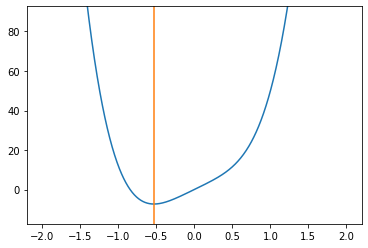

In [31]:
test(lambda A, c, gamma, state: 
     solve_auxilary_problem_utu(A, c, gamma, 
                                lambda T, c_tilda, gamma, tau_0: solve_auxilary_subproblem_analytic_vanilla_gd(T, c_tilda, gamma, tau_0, learning_rate=0.001, n_iter=1000), 
                                state), 
    100)

A = tensor([[0.0248, 0.0000, 0.0000, 0.0000],
        [0.0000, 1.1312, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0939, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.9684]]) 

c = tensor([ 0.0000, 21.9000,  0.0000,  0.0000]) 

gamma = tensor([19.3540]) 

Time: 0.0015530343109276146 

h = tensor([ 0.0000, -1.0233,  0.0000,  0.0000], grad_fn=<MvBackward>)


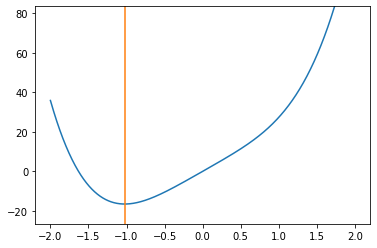

In [32]:
test(lambda A, c, gamma, state: 
     solve_auxilary_problem_utu(A, c, gamma, 
                                lambda T, c_tilda, gamma, tau_0: solve_auxilary_subproblem_analytic_gd_grad_norm(T, c_tilda, gamma, tau_0, learning_rate=0.1), 
                                state), 
    1000)

A = tensor([[0.9833, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.6474, 0.0000, 0.0000],
        [0.0000, 0.0000, 1.0779, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0052]]) 

c = tensor([ 0.0000, 14.3886,  0.0000,  0.0000]) 

gamma = tensor([143.1189]) 

Time: 0.0006677610827464377 

h = tensor([ 0.0000, -0.4617,  0.0000,  0.0000], grad_fn=<MvBackward>)


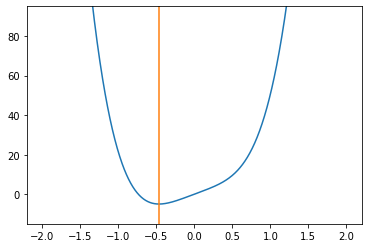

In [33]:
test(lambda A, c, gamma, state: 
     solve_auxilary_problem_utu(A, c, gamma, 
                                lambda T, c_tilda, gamma, tau_0: solve_auxilary_subproblem_newton(T, c_tilda, gamma, tau_0), 
                                state), 
    1000)

# Bregman-distance gradient method

In [34]:
def BDGM_newton(f, x_tilda_k, eps, L3):
    f_x_tilda_k = f(x_tilda_k)
    g_x_tilda_k = gradient(f_x_tilda_k, x_tilda_k, retain_graph=True)
    H_x_tilda_k = hessian(f_x_tilda_k, x_tilda_k)
    
    g_x_tilda_k_norm = torch.norm(g_x_tilda_k)
    
    alpha = 2 + math.sqrt(2)
    A = alpha * H_x_tilda_k
    gamma = L3 * alpha
    
    delta = 0.001 * eps**1.5 / (g_x_tilda_k_norm**0.5 + torch.norm(H_x_tilda_k)**1.5 / L3**0.5)
    
    z_0 = x_tilda_k
    tau = 3 * delta / (8 * alpha * g_x_tilda_k_norm)
    
    def g_x_tilda_k_tau():  # z = z_i, h_i = z - x_tilda_k
        x_p = x_tilda_k + tau * h_i
        grad_g_p = gradient(f(x_p), x_p)
        x_n = x_tilda_k - tau * h_i
        grad_g_n = gradient(f(x_n), x_n)
        r = 1 / tau**2 * (grad_g_p + grad_g_n - 2 * g_x_tilda_k)
        return r
    
    def g_phi_k_tau():  # z = z_i, h_i = z - x_tilda_k
        return g_x_tilda_k + g_x_tilda_k_tau() + u_i
    
    z_i = z_0
    while True:
        h_i = z_i - x_tilda_k
        u_i = H_x_tilda_k @ h_i + L3 * (h_i**2).sum() * h_i
        g_phi_k_tau_z_i = g_phi_k_tau()
        grad_f_z_i = gradient(f(z_i), z_i)
        if torch.norm(g_phi_k_tau_z_i) <= 1 / 6 * torch.norm(grad_f_z_i) - delta:
            break
        else:
            c = g_phi_k_tau_z_i - alpha * u_i
            h = solve_auxilary_problem_exact_newton(A, c, gamma, h_i)
            z_i = h + x_tilda_k

    return z_i

In [35]:
def BDGM_utu(f, x_tilda_k, eps, L3):
    f_x_tilda_k = f(x_tilda_k)
    g_x_tilda_k = gradient(f_x_tilda_k, x_tilda_k, retain_graph=True)
    H_x_tilda_k = hessian(f_x_tilda_k, x_tilda_k)
    
    g_x_tilda_k_norm = torch.norm(g_x_tilda_k)
    
    alpha = 2 + math.sqrt(2)
    A = alpha * H_x_tilda_k
    gamma = L3 * alpha
    
    T, U = utu_decomposition(A)
    tau_0 = torch.tensor(1, dtype=torch.float32, requires_grad=True)
    state = T, U, tau_0
    
    delta = 0.001 * eps**1.5 / (g_x_tilda_k_norm**0.5 + torch.norm(H_x_tilda_k)**1.5 / L3**0.5)
    
    z_0 = x_tilda_k
    tau = 3 * delta / (8 * alpha * g_x_tilda_k_norm)
    
    def g_x_tilda_k_tau():  # z = z_i, h_i = z - x_tilda_k
        x_p = x_tilda_k + tau * h_i
        grad_g_p = gradient(f(x_p), x_p)
        x_n = x_tilda_k - tau * h_i
        grad_g_n = gradient(f(x_n), x_n)
        r = 1 / tau**2 * (grad_g_p + grad_g_n - 2 * g_x_tilda_k)
        return r
    
    def g_phi_k_tau():  # z = z_i, h_i = z - x_tilda_k
        return g_x_tilda_k + g_x_tilda_k_tau() + u_i
    
    z_i = z_0
    while True:
        h_i = z_i - x_tilda_k
        u_i = H_x_tilda_k @ h_i + L3 * (h_i**2).sum() * h_i
        g_phi_k_tau_z_i = g_phi_k_tau()
        grad_f_z_i = gradient(f(z_i), z_i)
        if torch.norm(g_phi_k_tau_z_i) <= 1 / 6 * torch.norm(grad_f_z_i) - delta:
            break
        else:
            c = g_phi_k_tau_z_i - alpha * u_i
            h, state = solve_auxilary_problem_utu(A, c, gamma, solve_auxilary_subproblem_newton, state)
            z_i = h + x_tilda_k

    return z_i

In [36]:
def test(solve, N):
    def f(x):
        return torch.nn.functional.binary_cross_entropy_with_logits(X @ x, y)

    L3 = 5
    eps = 1e-5
    
    def phi_k(z):
        y = z - x_tilda_k
        return g @ y + h @ y @ y + d3 @ y @ y @ y + L3 * torch.norm(y)**4 / 4

    def is_feasible(z):
        return torch.norm(z - x_tilda_k) <= 2 * ((2 + math.sqrt(2)) * torch.norm(g) / L3) ** (1/3)

    times = []
    for _ in range(N):
        x_tilda_k = torch.randn(31, requires_grad=True)
        f_x_tilda_k = f(x_tilda_k)
        g = gradient(f_x_tilda_k, x_tilda_k, retain_graph=True)
        h = hessian(f_x_tilda_k, x_tilda_k)
        d3 = D3(f_x_tilda_k, x_tilda_k)
        
        start = clock_gettime(CLOCK_MONOTONIC)
        z_opt = solve(f, x_tilda_k, eps, L3)
        end = clock_gettime(CLOCK_MONOTONIC)
        times.append(end - start)
        
        assert is_feasible(z_opt)
        assert check_optimality(phi_k, z_opt, eps=1e-3)
    
    print('Time:', np.mean(times))

In [37]:
test(BDGM_newton, 100)

Time: 0.028133713390125194


In [38]:
test(BDGM_utu, 100)

Time: 0.020796119529986754


# Hyperfast Second-Order Method

In [39]:
def square_norm(x):
    return torch.sum(x**2)

def hyperfast_second_order_method(f, y_0, K, L3, eps):
    A_0 = 0
    x_0 = y_0 

    x_tilda_k = x_0
    A_k = A_0
    x_k = x_0
    y_k = y_0

    for k in range(K):
        y_k_plus_1 = BDGM_utu(f, x_tilda_k, eps, L3)

        sn = square_norm(y_k_plus_1 - x_tilda_k)
        lambda_min = 2 / (3 * L3 * sn)
        lambda_max = 1 / (L3 * sn)
        lambda_k_plus_1 = (lambda_min + lambda_max) / 2

        a_k_plus_1 = 1 / 2 * (lambda_k_plus_1 +
                              (lambda_k_plus_1 ** 2 +
                               4 * lambda_k_plus_1 * A_k) ** 0.5)
        A_k_plus_1 = a_k_plus_1 + A_k
        x_tilda_k = A_k * y_k / A_k_plus_1 + a_k_plus_1 * x_k / A_k_plus_1
        x_k = x_k - a_k_plus_1 * gradient(f(y_k_plus_1), y_k_plus_1)
        
        A_k = A_k_plus_1
        y_k = y_k_plus_1

    return y_k

In [40]:
def test(N):
    L3 = 5
    eps = 1e-5
    delta = 1e-9
    K = 50
    
    def f(x):
        return torch.nn.functional.binary_cross_entropy_with_logits(X @ x, y)
    
    times = []
    for _ in range(N):
        y_0 = torch.randn(31, requires_grad=True)
        start = clock_gettime(CLOCK_MONOTONIC)
        y_opt = hyperfast_second_order_method(f, y_0, K, L3, eps)
        end = clock_gettime(CLOCK_MONOTONIC)
        times.append(end - start)
    
    print('Time:', np.mean(times))
    
    print('y_opt', y_opt)
    print('f(y_opt) =', f(y_opt))
    print('y_opt is optimal:', check_optimality(f, y_opt, eps=1e-1))
    print('y_opt is optimal:', check_optimality(f, y_opt, eps=1e-2))
    print('y_opt is optimal:', check_optimality(f, y_opt, eps=1e-3))
    print('y_opt is optimal:', check_optimality(f, y_opt, eps=1e-4))
    print('y_opt is optimal:', check_optimality(f, y_opt, eps=1e-5))
    print('y_opt is optimal:', check_optimality(f, y_opt, eps=1e-6))
    print('y_opt is optimal:', check_optimality(f, y_opt, eps=1e-7))

test(1)

Time: 7.32409562500834
y_opt tensor([-0.4830, -0.6889, -0.4309, -0.4320, -0.4833, -0.4560, -0.4552, -0.4545,
        -0.0914,  0.4990, -0.4841,  0.1016, -0.0853, -0.0380, -0.1502,  0.0855,
         0.2174, -0.0329,  0.3647,  0.0480, -0.1783, -0.6496, -0.7155, -0.1155,
         0.0680, -0.0602, -0.7559, -0.8994, -0.6387,  0.1182,  1.3293],
       grad_fn=<AddBackward0>)
f(y_opt) = tensor(0.1454, grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
y_opt is optimal: True
y_opt is optimal: True
y_opt is optimal: True
y_opt is optimal: True
y_opt is optimal: True
y_opt is optimal: True
y_opt is optimal: True
